In [57]:

import os
import sys
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchinfo import summary
import os
import sys
import matplotlib.pyplot as plt
import argparse
import shutil
import pandas as pd
from sklearn.model_selection import train_test_split


In [58]:
import TRACK_POS, TRACK_SAL
import position_dataset

In [59]:
from Utils import cartesian_to_eulerian, eulerian_to_cartesian, get_max_sal_pos,load_dict_from_csv,all_metrics, store_list_as_csv, MetricOrthLoss, OrthDist
from data_utils import fan_nossdav_split, PositionDataset
from DatasetHelper import get_video_length,read_sampled_unit_vectors_for_video,read_sampled_unit_vectors_by_users, read_sampled_positions_for_trace, load_saliency, load_true_saliency, get_video_ids, get_user_ids, get_users_per_video, split_list_by_percentage, partition_in_train_and_test_without_any_intersection, partition_in_train_and_test_without_video_intersection, partition_in_train_and_test

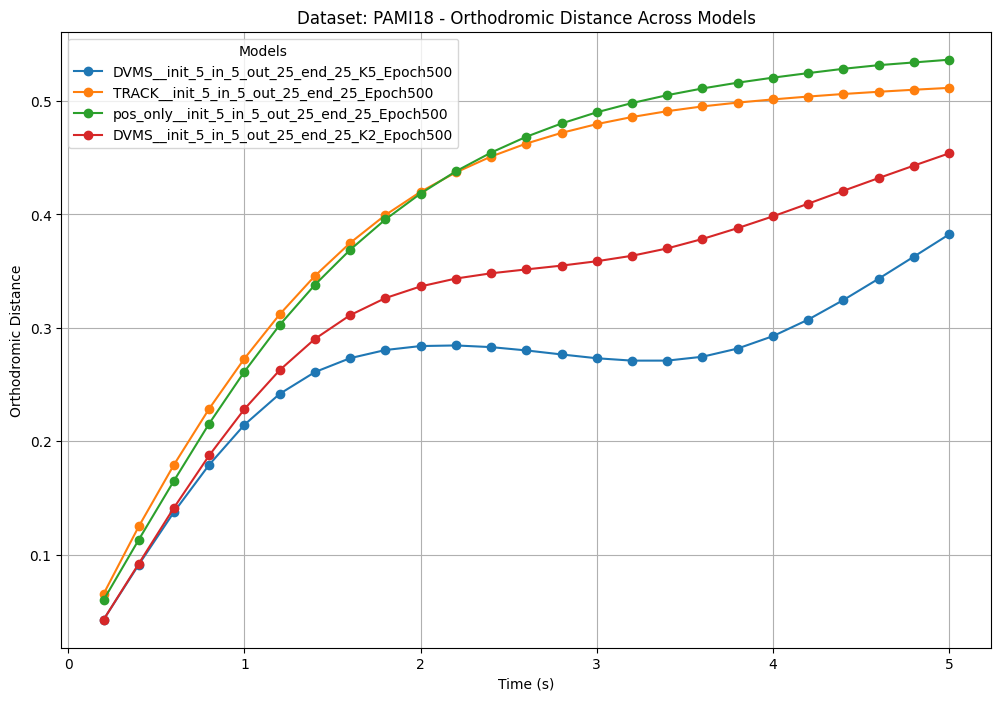

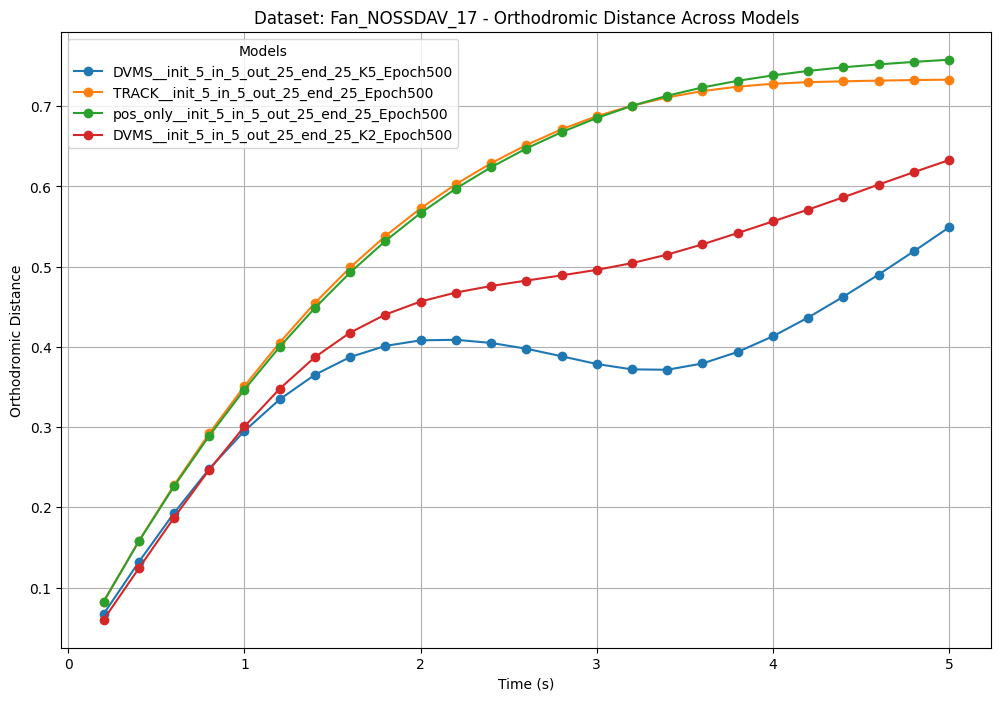

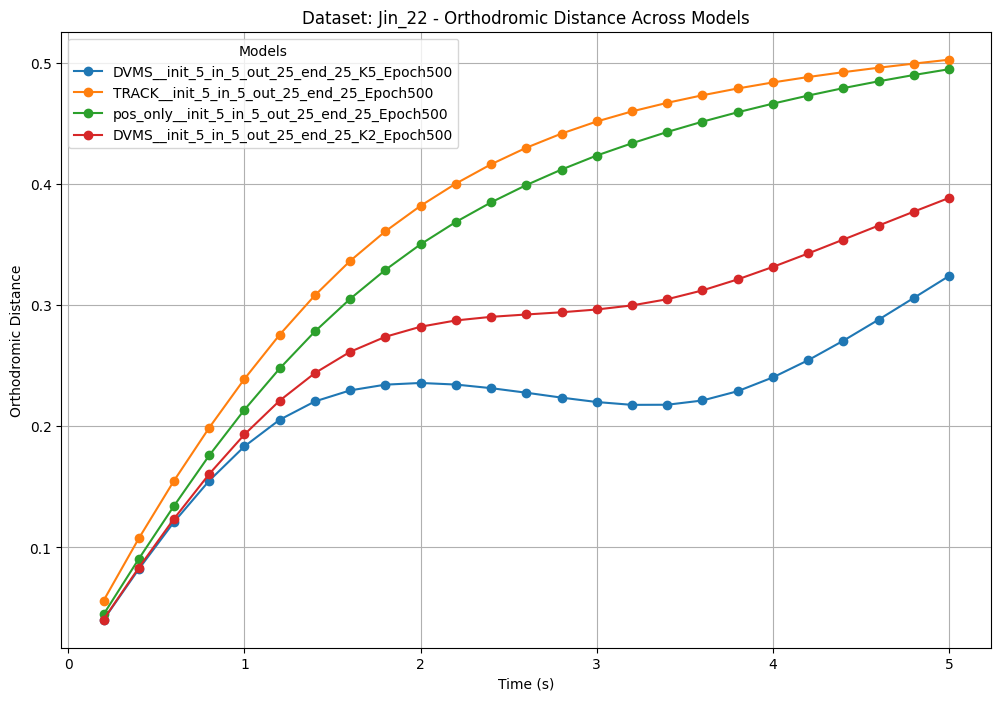

In [60]:
plot_paths='TestPlots'
datasets=os.listdir(plot_paths)
for dataset in datasets:
    paths=os.path.join(plot_paths,dataset)
    models=os.listdir(paths)
    model_dist_values = {}
    for model in models:
        model_path=os.path.join(paths,model)
        dist_values_path=os.path.join(model_path,'orth_dist_values.npy')
        if os.path.exists(dist_values_path):
            # Load the dist_values from the file
            dist_values = np.load(dist_values_path)
            
            # Store dist_values in the dictionary with model name as key
            model_dist_values[model] = dist_values
        else:
            print(f"File {dist_values_path} does not exist.")
    if model_dist_values:
        # Generate the timestamps based on 5fps
        timestamps = np.arange(0.2, 5.1, 0.2)  # Adjust according to your timestamp range and fps
        
        # Plotting
        plt.figure(figsize=(12, 8))
        
        # Plot each model's dist_values with a label
        for model, dist_values in model_dist_values.items():
            plt.plot(timestamps, dist_values, marker='o', linestyle='-', label=model)
        
        plt.title(f'Dataset: {dataset} - Orthodromic Distance Across Models')
        plt.xlabel('Time (s)')
        plt.ylabel('Orthodromic Distance')
        plt.legend(title='Models')
        plt.grid(True)
        
        # Save plot to the dataset path
        #plot_file = os.path.join(dataset_path, 'combined_dist_values_plot.png')
        #plt.savefig(plot_file)
        plt.show()
        plt.close()
        
        #print(f"Plot saved at: {plot_file}")
    else:
        print(f"No dist_values found for dataset: {dataset}")

In [61]:
def fetch_entropies(datasets_folder,dataset, videos):
    dataset_folder = os.path.join(datasets_folder, dataset)
    #video_img_folder = os.path.join(dataset_folder, '5fps_Video_Images')
    data_path = os.path.join(dataset_folder, 'video_data')
    #videos = os.listdir(video_img_folder)
    entropies={}
    aes={}
    IEs={}
    for video in videos:
        entropy_path = os.path.join(data_path, video, f'{video}_content_entropy.npy')
        ae_path=os.path.join(data_path,video, f'{video}_AEs.npy')
        IE_path=os.path.join(data_path, video, f'{video}_IEs.npy')
        entropy=np.load(entropy_path)
        ae=np.load(ae_path)
        ie=np.load(IE_path)
        entropies[video]=entropy
        aes[video]=ae
        IEs[video]=ie
    return entropies,aes,IEs

In [93]:
def get_mean_test_accuracies(dataset):
    paths=os.path.join(plot_paths,dataset)
    models=os.listdir(paths)
    temp_path=os.path.join(paths,models[0])
    videos=os.listdir(temp_path)
    # Generate unique colors
    num_videos = len(videos)
    #entropies,aes,IEs=fetch_entropies(datasets_folder,dataset,videos)
    #fig=plot_mean_AEs_vs_entropy(entropies,aes,dataset, video_colors)
    model_dist_values={}
    for model in models:
        model_path=os.path.join(paths,model)
        
        for video in videos:
            video_path=os.path.join(model_path,video)
            #print(video_path)
            dist_values_path=os.path.join(video_path,'orth_dist_values.npy')
            if os.path.exists(dist_values_path):
                # Load the dist_values from the file
                dist_values = np.load(dist_values_path)
                if model not in model_dist_values:
                        model_dist_values[model] = {}
                # Store dist_values in the dictionary with model name as key
                model_dist_values[model][video] = np.mean(dist_values)
            else:
                print(f"File {dist_values_path} does not exist.")
    return model_dist_values

In [85]:
def plot_mean_AEs_vs_entropy(entropies, aes,dataset,video_colors):
    mean_entropies = []
    mean_AEs = []
    fig, ax = plt.subplots(figsize=(8, 6))
    for video,color in video_colors.items():
        mean_entropies.append(np.mean(entropies[video]))
        mean_AEs.append(np.mean(aes[video]))
        mean_entropy = np.mean(entropies[video])
        mean_AE = np.mean(aes[video])
        ax.scatter(mean_AE, mean_entropy, color=color, marker='o', label=video)
        ax.annotate(video, (mean_AE, mean_entropy), fontsize=8, ha='right', color='black')
    
    #plt.figure(figsize=(8, 6))
    #plt.scatter(mean_AEs, mean_entropies, color=color, marker='o')
    #for i, video in enumerate(entropies):
    #    plt.annotate(video, (mean_AEs[i], mean_entropies[i]), fontsize=8)
    #plt.title(f'Test videos {dataset} Mean Entropy vs Mean AE')
    #plt.xlabel('Mean AEs')
    #plt.ylabel('Mean Content Entropy')
    #plt.grid(True)
    #plots_folder = os.path.join('Plots', 'Entropies')
    #os.makedirs(plots_folder, exist_ok=True)not 
    #plot_path = os.path.join(plots_folder, f'{dataset}_contententropy_vs_AE.png')
    #plt.savefig(plot_path)
    # Create a new figure and axis
    
    mean_dist_values=
    # Plot the data
    ax.set_title(f'Test videos {dataset} Mean Entropy vs Mean AE')
    ax.set_xlabel('Mean AEs')
    ax.set_ylabel('Mean Content Entropy')
    ax.grid(True)
    
    # Return the figure
    return fig
    #return plt

In [86]:
def generate_unique_colors(n_colors):
    """
    Generate a list of unique colors.
    :param n_colors: Number of unique colors needed
    :return: List of unique colors
    """
    colormap = plt.get_cmap('tab20')  # You can choose a different colormap if needed
    colors = [colormap(i / n_colors) for i in range(n_colors)]
    return colors

In [97]:
plot_paths='Test_vid_plots'
datasets=os.listdir(plot_paths)
datasets_folder='/media/Blue2TB1'
timestamps = np.arange(0.2, 5.1, 0.2)
def plot_test_entropies(dataset):
    paths=os.path.join(plot_paths,dataset)
    models=os.listdir(paths)
    temp_path=os.path.join(paths,models[0])
    videos=os.listdir(temp_path)
    # Generate unique colors
    num_videos = len(videos)
    colors = generate_unique_colors(num_videos)
    # Create a mapping of videos to colors
    video_colors = dict(zip(videos, colors))
    entropies,aes,IEs=fetch_entropies(datasets_folder,dataset,videos)
    fig=plot_mean_AEs_vs_entropy(entropies,aes,dataset, video_colors)

In [94]:
def plot_combined_distances_for_model(dist_values_per_video, video_colors, model, ax,dataset):
    """Plot combined orthodromic distances for all videos in a model."""
    timestamps = np.arange(0.2, 5.1, 0.2)  # 0.2 to 5 seconds with 5 fps
    
    for video, dist_values in dist_values_per_video.items():
        color = video_colors.get(video, 'black')  # Default to 'black' if video color not found
        ax.plot(timestamps, dist_values, marker='o', linestyle='-', color=color, label=video)
    
    ax.set_title(f'Model: {model} - Orthodromic Distances Across Videos for {dataset}')
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Orthodromic Distance')
    ax.legend(loc='best', fontsize='small')
    ax.grid(True)

In [95]:
def plot_video_charts(dataset):
    paths=os.path.join(plot_paths,dataset)
    models=os.listdir(paths)
    temp_path=os.path.join(paths,models[0])
    videos=os.listdir(temp_path)
    # Generate unique colors
    num_videos = len(videos)
    colors = generate_unique_colors(num_videos)
    # Create a mapping of videos to colors
    video_colors = dict(zip(videos, colors))
    #entropies,aes,IEs=fetch_entropies(datasets_folder,dataset,videos)
    #fig=plot_mean_AEs_vs_entropy(entropies,aes,dataset, video_colors)
    model_dist_values={}
    for model in models:
        model_path=os.path.join(paths,model)
        
        for video in videos:
            video_path=os.path.join(model_path,video)
            #print(video_path)
            dist_values_path=os.path.join(video_path,'orth_dist_values.npy')
            if os.path.exists(dist_values_path):
                # Load the dist_values from the file
                dist_values = np.load(dist_values_path)
                if model not in model_dist_values:
                        model_dist_values[model] = {}
                # Store dist_values in the dictionary with model name as key
                model_dist_values[model][video] = dist_values
            else:
                print(f"File {dist_values_path} does not exist.")
    for model, dist_values_per_video in model_dist_values.items():
            fig, ax = plt.subplots(figsize=(12, 8))
            plot_combined_distances_for_model(dist_values_per_video, video_colors, model, ax, dataset)
            
            #plot_file = os.path.join(output_path, f'{dataset}_{model}_combined_distances.png')
            plt.tight_layout()
            #plt.savefig(plot_file)
            plt.show()
            
            #print(f"Combined distances plot saved at: {plot_file}")
    
    

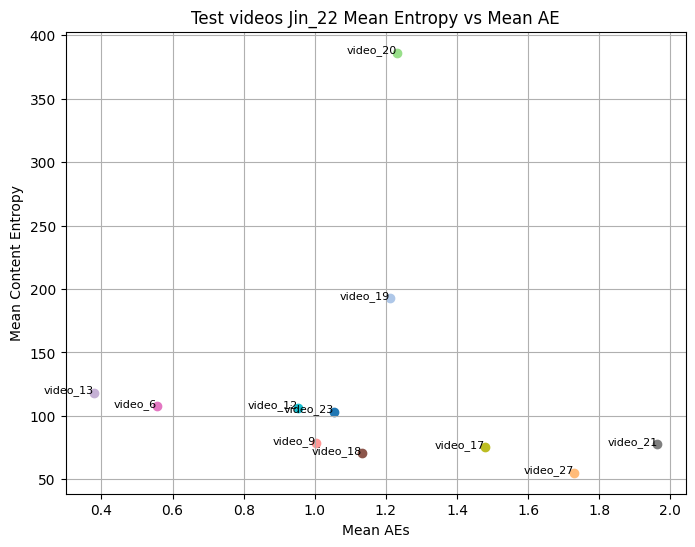

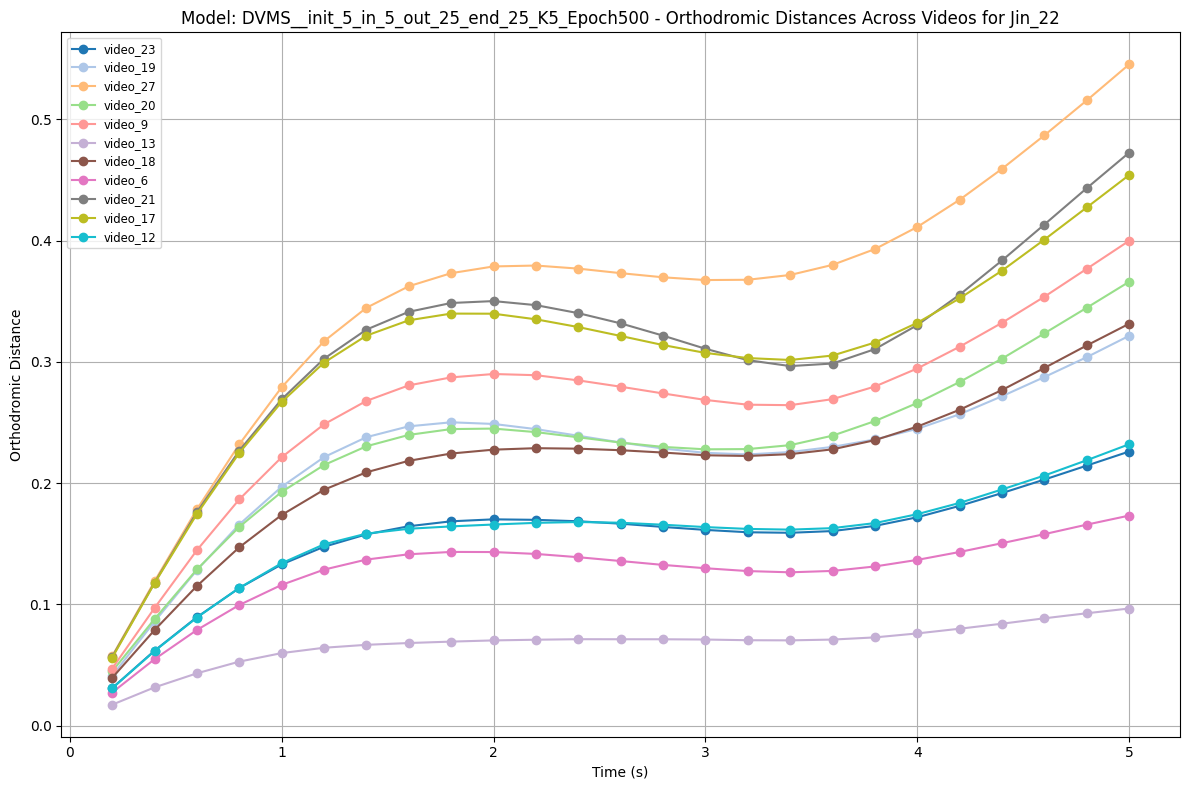

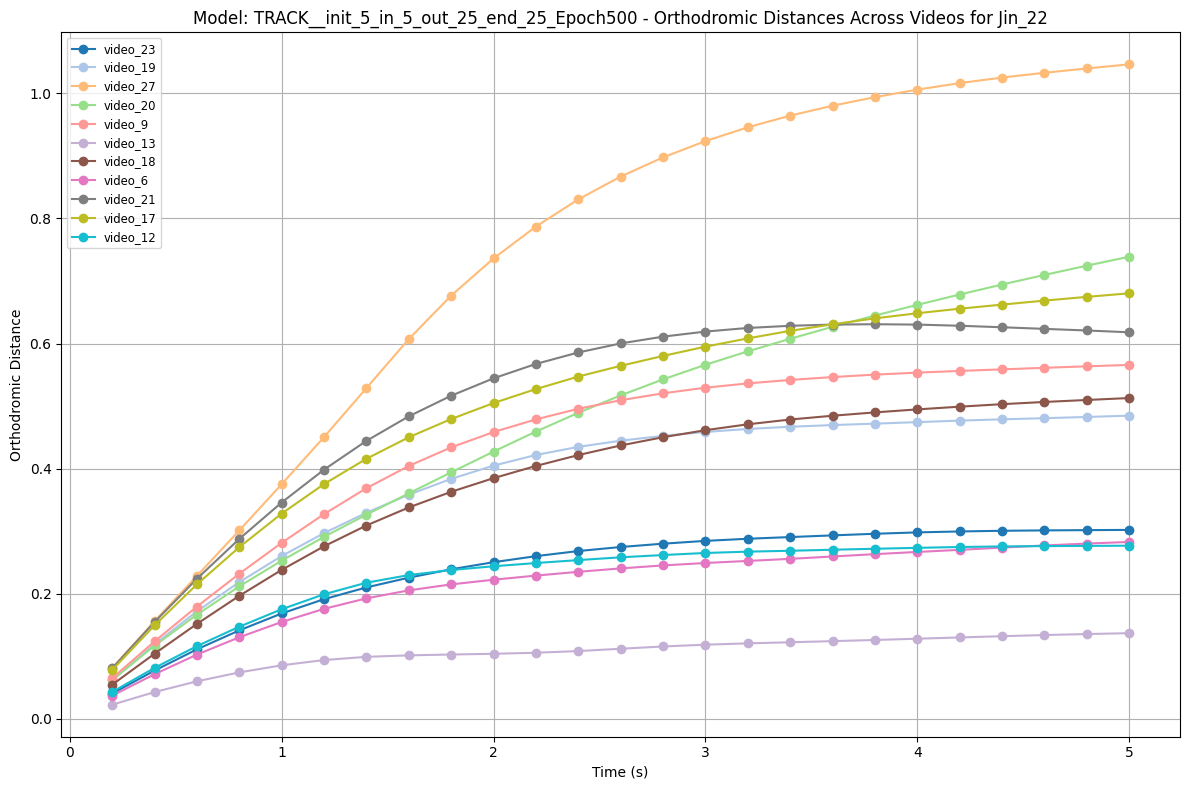

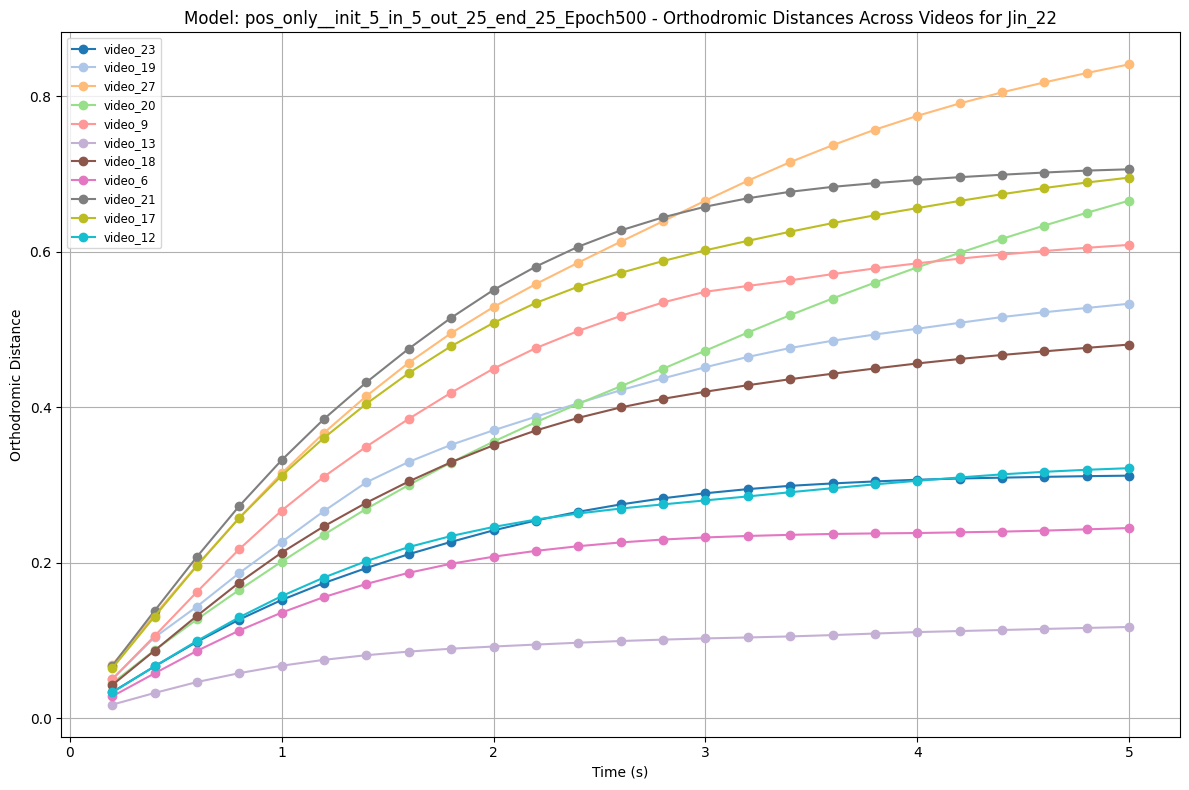

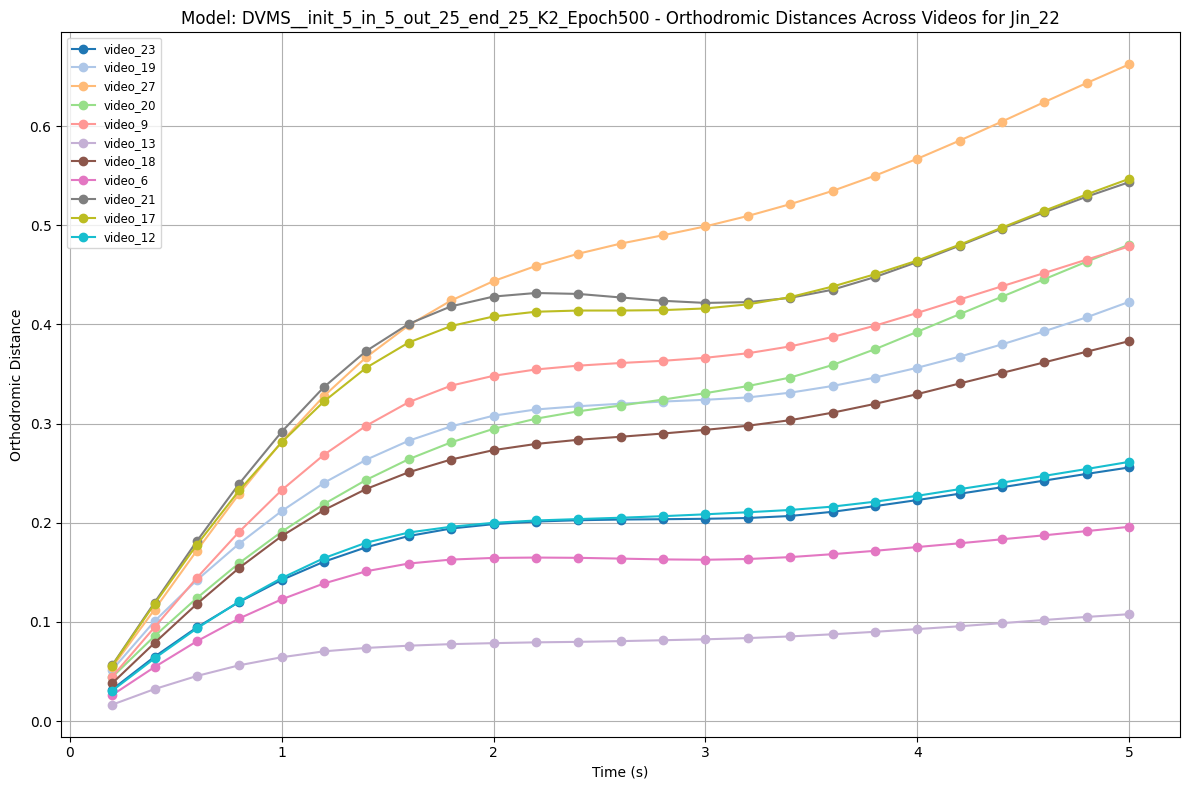

In [98]:
plot_test_entropies('Jin_22')
plot_video_charts('Jin_22')

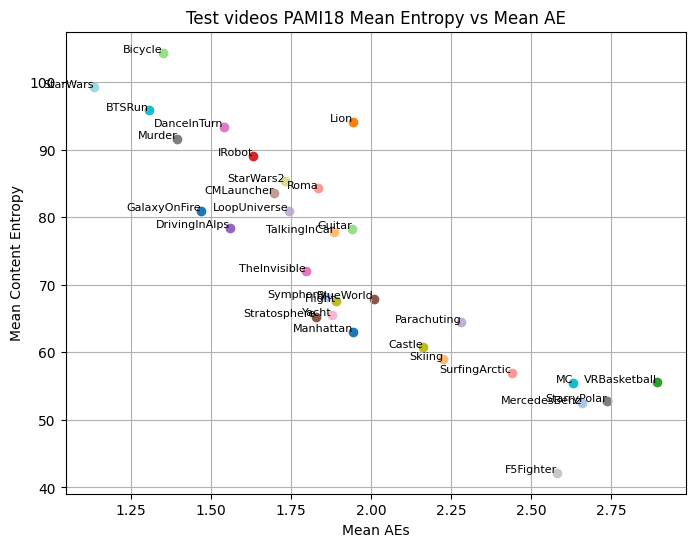

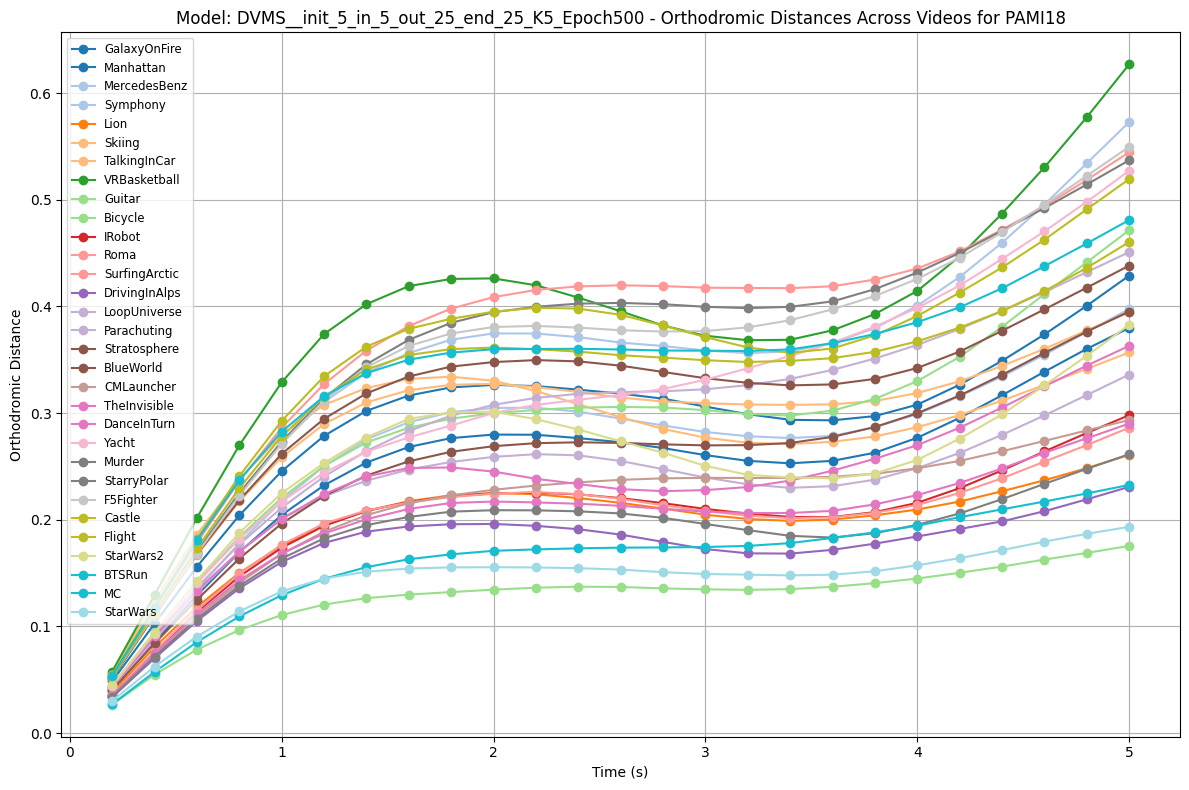

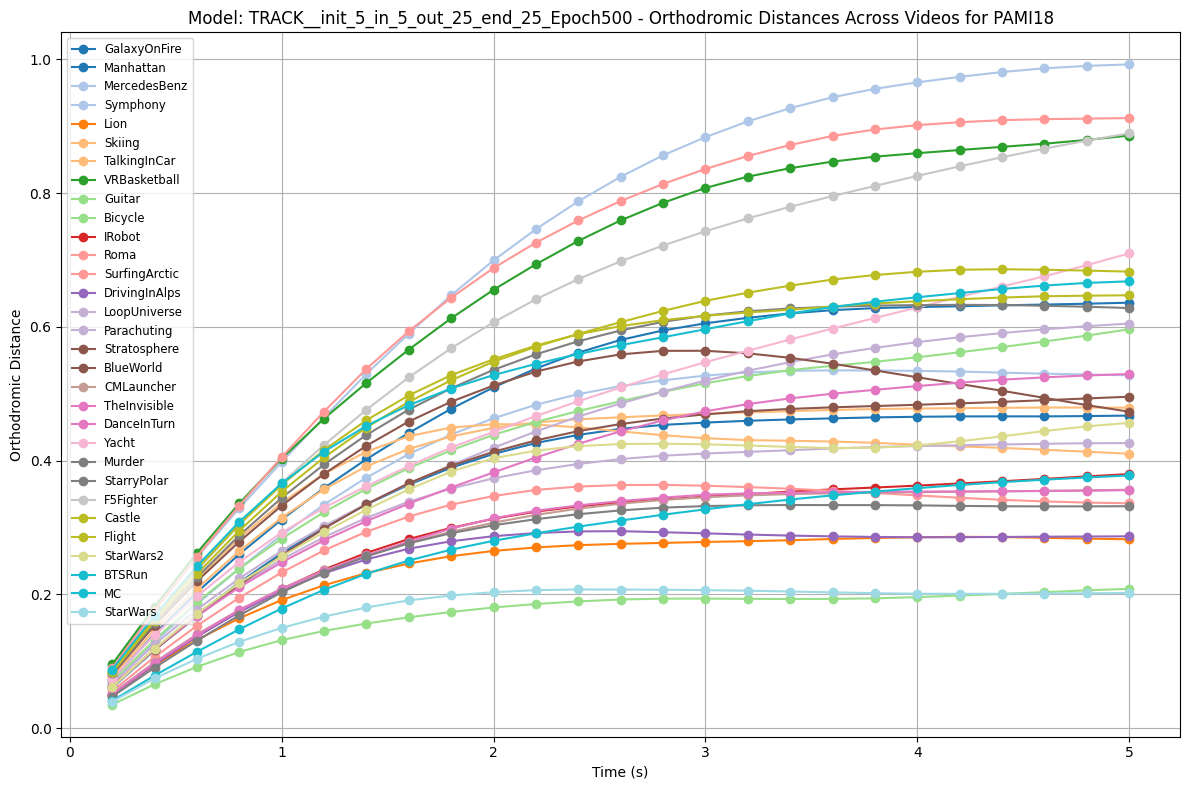

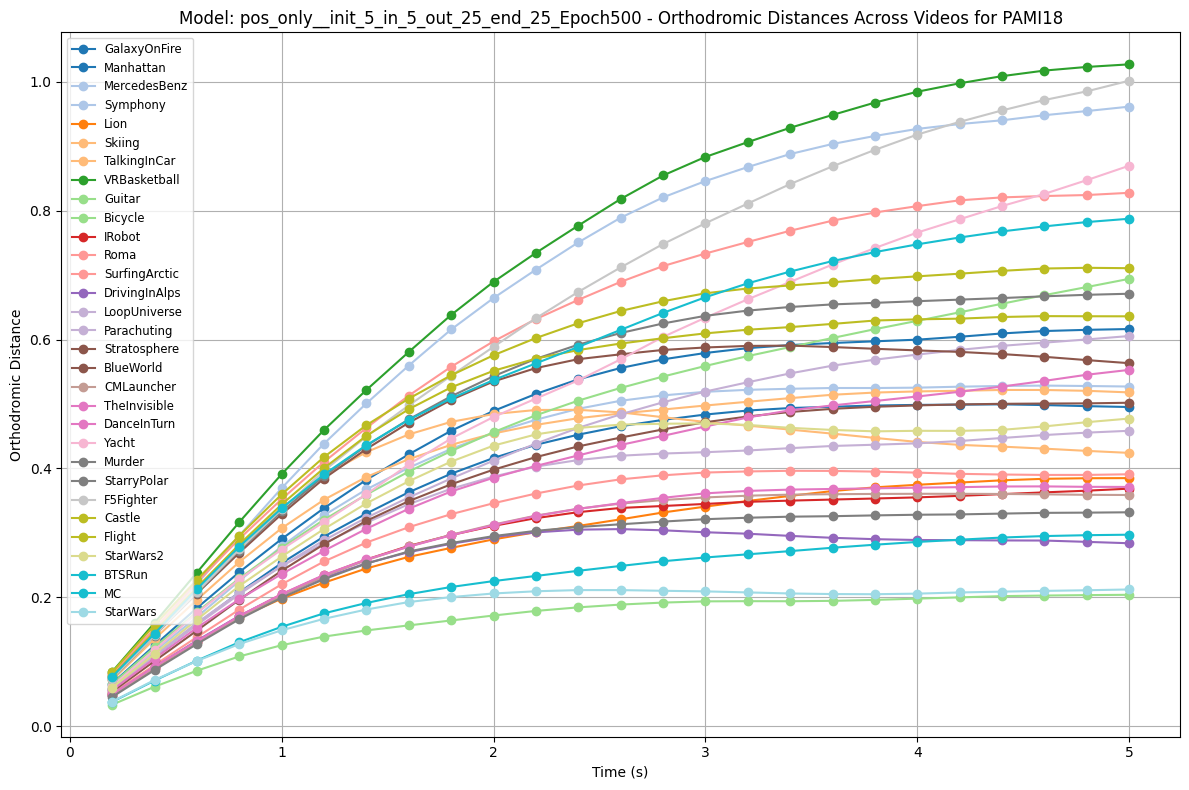

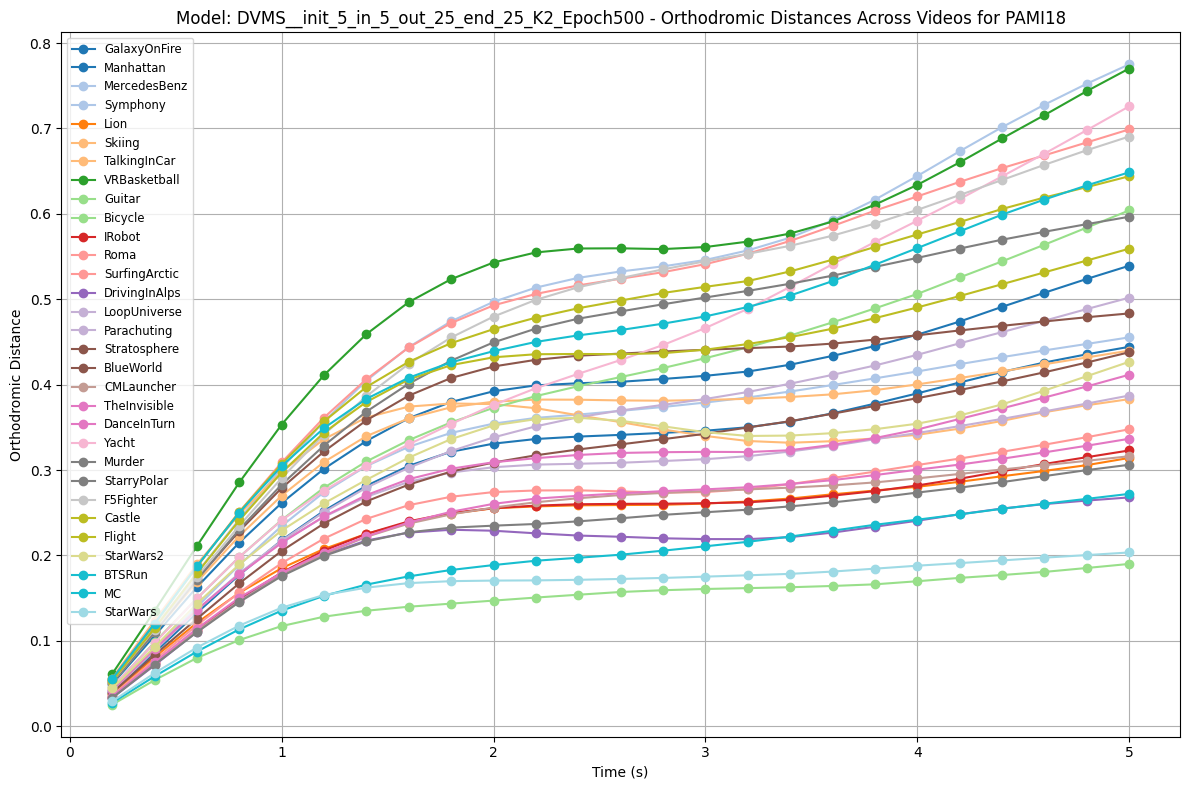

In [99]:
plot_test_entropies('PAMI18')
plot_video_charts('PAMI18')

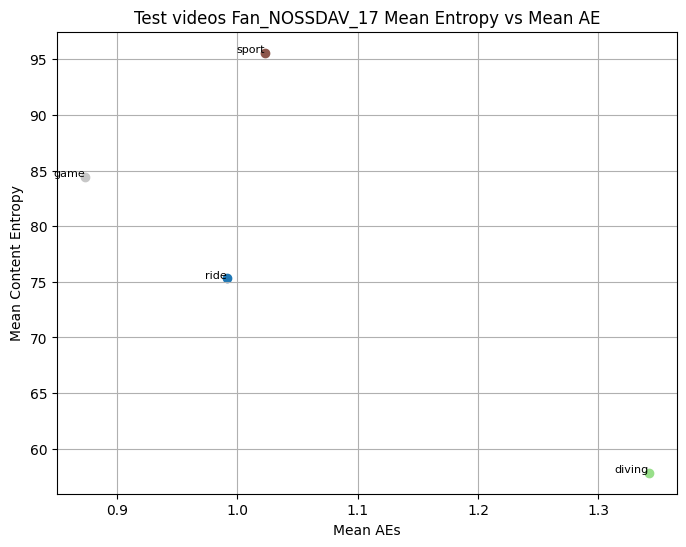

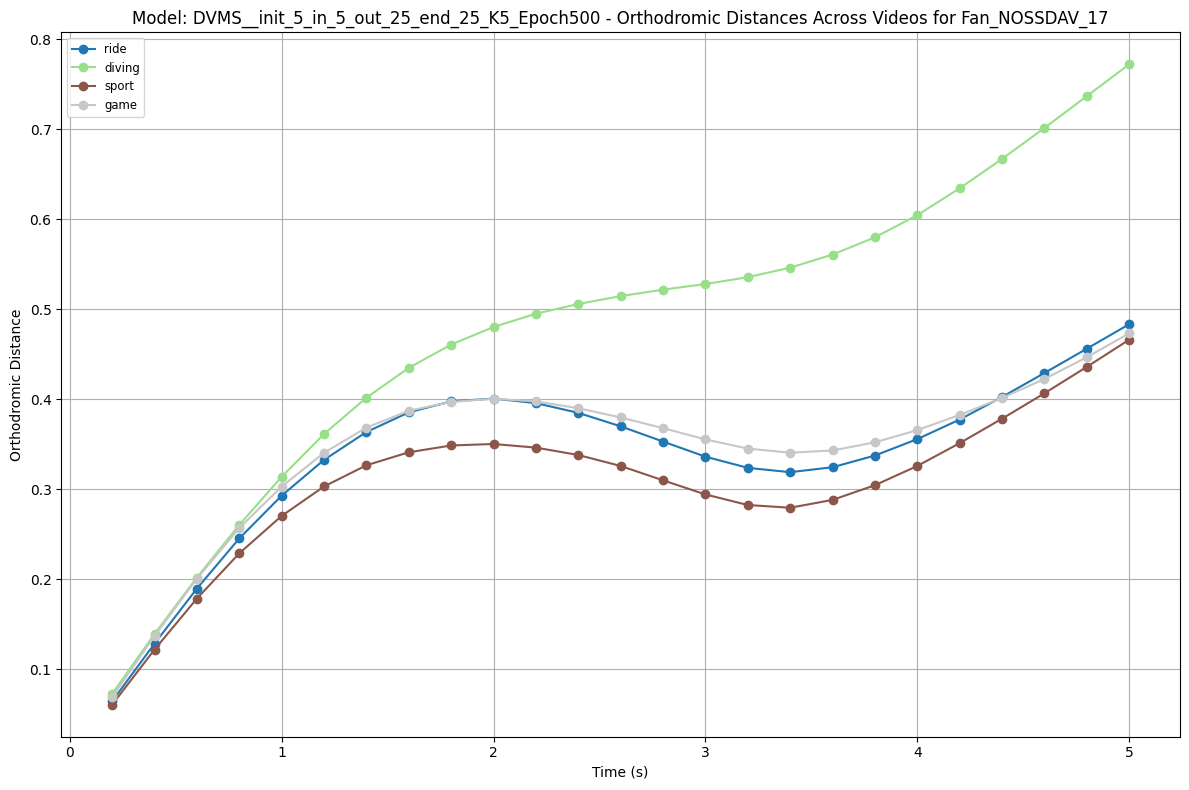

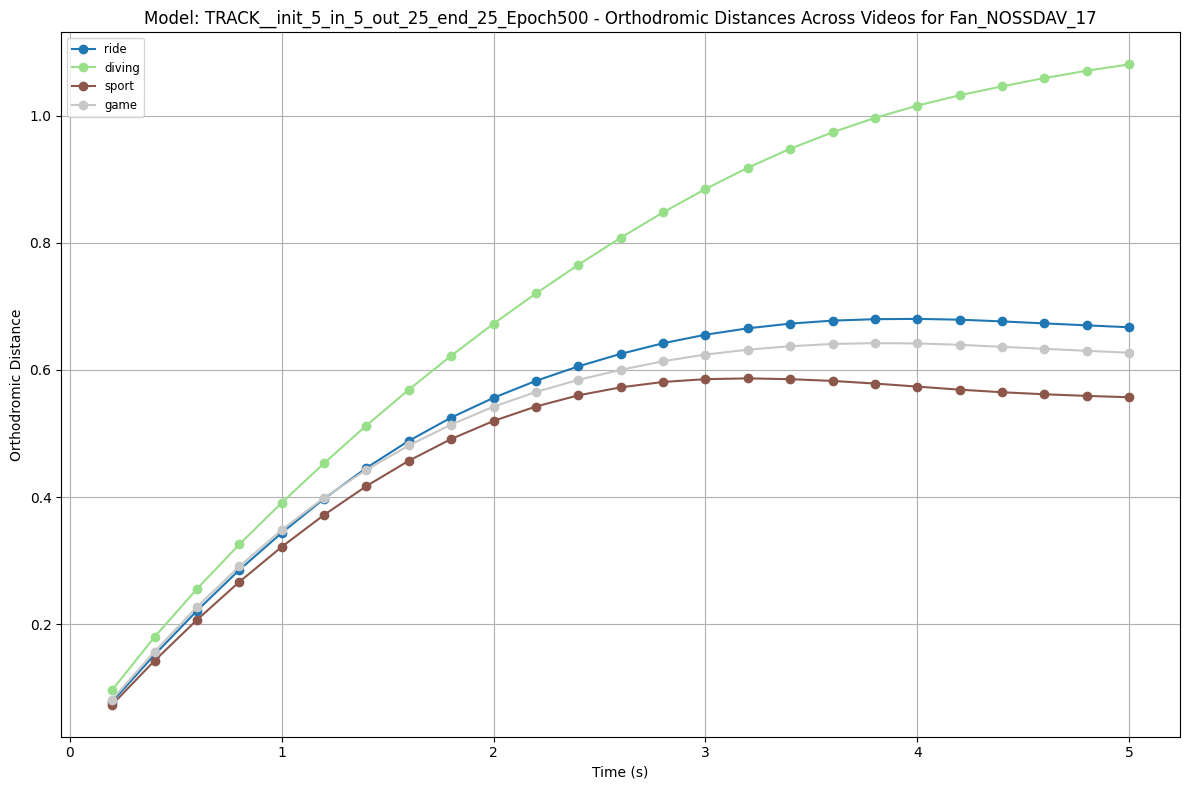

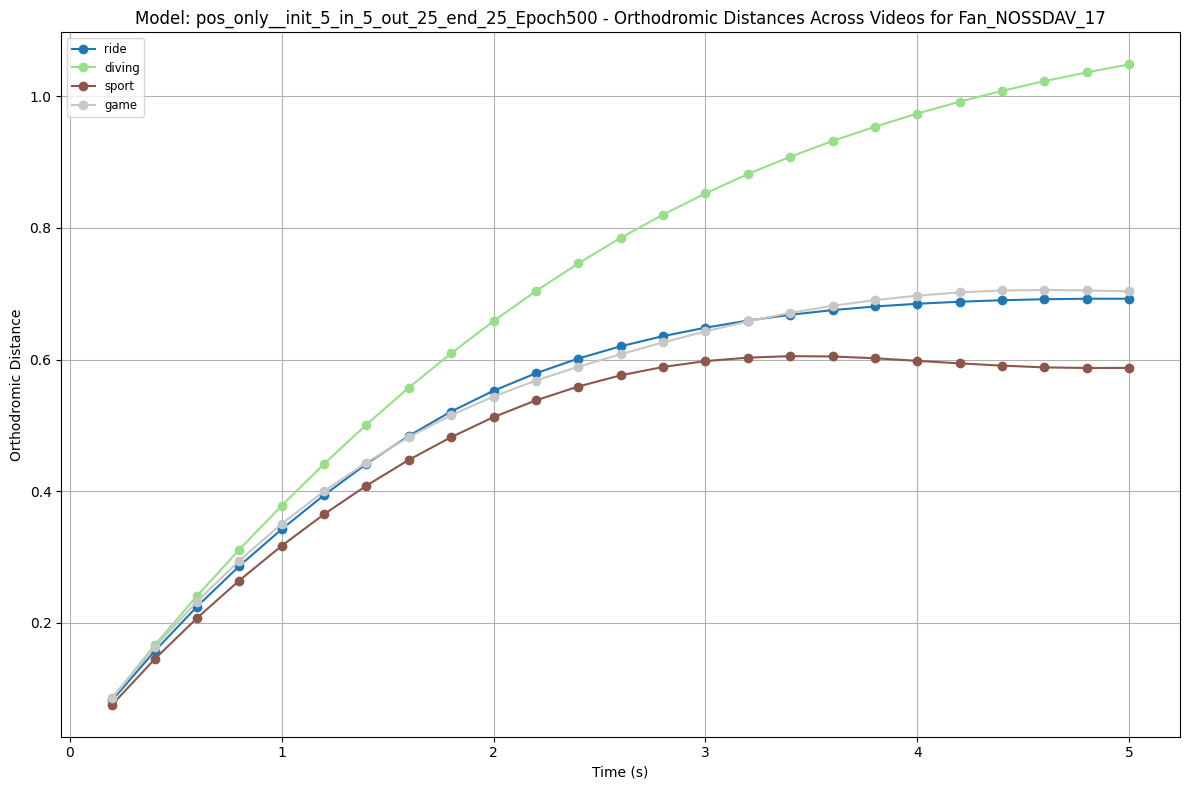

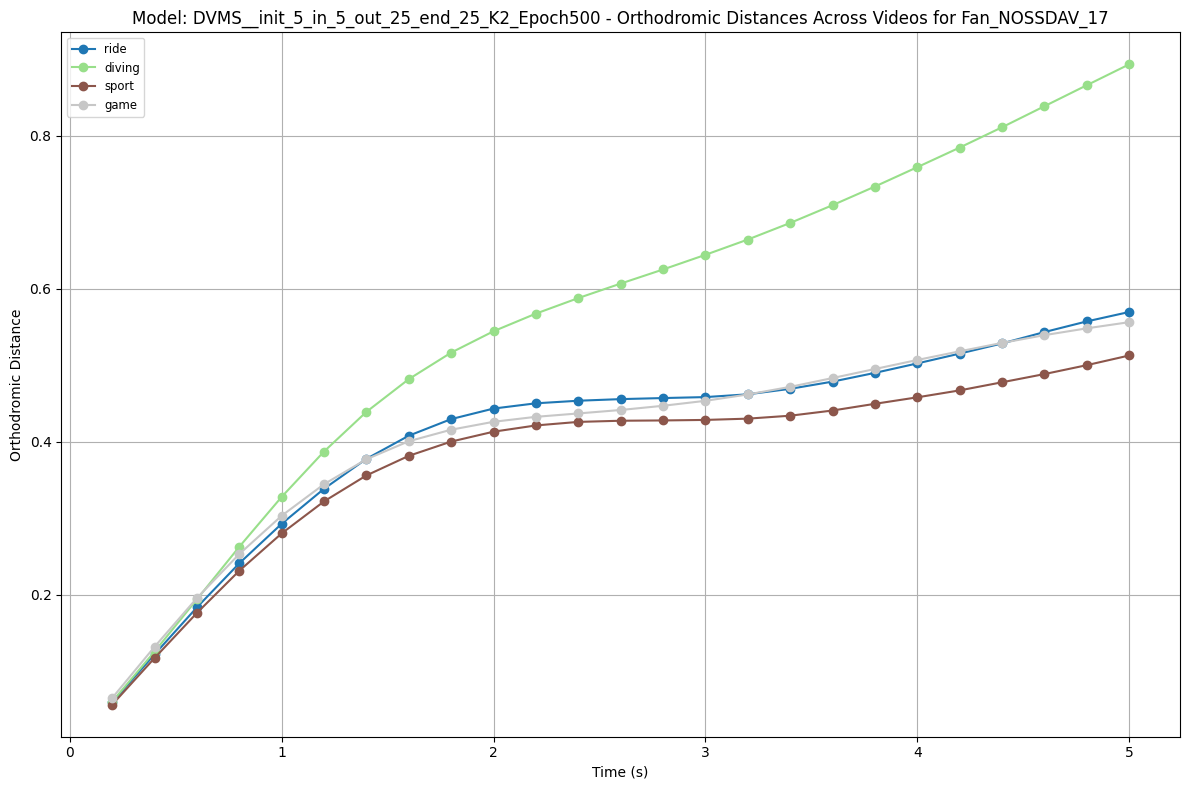

In [101]:
plot_test_entropies('Fan_NOSSDAV_17')
plot_video_charts('Fan_NOSSDAV_17')

In [4]:
if torch.cuda.is_available():
    device=torch.device("cuda")
    print("Using GPU")
#dataset_name="Jin_22"
dataset_name="Jin_22"
M_WINDOW=5
H_WINDOW=25
INIT_WINDOW=M_WINDOW
END_WINDOW=H_WINDOW
EPOCHS=500
NUM_TILES_WIDTH=480
NUM_TILES_HEIGHT=240
NUM_TILES_WIDTH_TRUE_SAL = 256
NUM_TILES_HEIGHT_TRUE_SAL = 256
RATE = 0.2
PERC_VIDEOS_TRAIN = 0.6
PERC_USERS_TRAIN = 0.6
BATCH_SIZE = 64
#model_name='TRACK'
model_name='TRACK'
root_folder='/media/Blue2TB1'
root_dataset_folder = os.path.join(root_folder, dataset_name)
EXP_NAME=f"_init_{INIT_WINDOW}_in_{M_WINDOW}_out_{H_WINDOW}_end_{END_WINDOW}"
SAMPLED_DATASET_FOLDER=os.path.join(root_dataset_folder,'sampled_dataset')
VIDEO_DATA_FOLDER=os.path.join(root_dataset_folder,'video_data')
SALIENCY_FOLDER = os.path.join(root_dataset_folder, 'extract_saliency/saliency')
TRUE_SALIENCY_FOLDER = os.path.join(root_dataset_folder, 'true_saliency')

Using GPU


In [5]:
videos = get_video_ids(VIDEO_DATA_FOLDER)
users = get_user_ids(VIDEO_DATA_FOLDER)
users_per_video = get_users_per_video(VIDEO_DATA_FOLDER)

In [6]:
split_path=os.path.join(dataset_name,"splits")
if os.path.exists(os.path.join(split_path,'train_set')):
    train_traces=load_dict_from_csv(os.path.join(split_path,'train_set'),columns=['user','video'])
    test_traces=load_dict_from_csv(os.path.join(split_path,'test_set'),columns=['user','video'])
    user_test_traces=load_dict_from_csv(os.path.join(split_path,'user_test_set'),columns=['user','video'])
    video_test_traces=load_dict_from_csv(os.path.join(split_path,'video_test_set'),columns=['user','video'])

In [7]:
partitions=partition_in_train_and_test(VIDEO_DATA_FOLDER,INIT_WINDOW,END_WINDOW,train_traces,test_traces,user_test_traces=user_test_traces,video_test_traces=video_test_traces)


In [8]:
all_traces = {}
for video in videos:
    all_traces[video] = read_sampled_unit_vectors_by_users(VIDEO_DATA_FOLDER, video,users_per_video[video])

In [9]:
all_traces['video_1']['user-1'].shape

(301, 3)

In [10]:
all_saliencies = {}
#for video in videos:
    #print(f"Loading {video} saliencies")
    #all_saliencies[video]=load_true_saliency(TRUE_SALIENCY_FOLDER,video)

In [11]:
train_data=PositionDataset(partitions['train'],future_window=H_WINDOW,M_WINDOW=M_WINDOW,all_traces=all_traces,model_name='DVMS',all_saliencies=None)
train_loader=DataLoader(train_data,batch_size=BATCH_SIZE,shuffle=True, pin_memory=True, num_workers=0)

In [12]:
for idx,(ip,targets) in enumerate(train_loader):
    ip=(t.squeeze(axis=1).float().to(device) for t in ip)
    for t in ip:
        print(t.shape)
    targets=targets.squeeze(axis=1).float().to(device)
    print(targets.shape)
    break

torch.Size([64, 5, 3])
torch.Size([64, 1, 3])
torch.Size([64, 25, 3])


In [13]:
#train_traces,test_traces,video_test_traces,user_test_traces=fan_nossdav_split(SAMPLED_DATASET_FOLDER,video_ratio=PERC_VIDEOS_TRAIN,user_ratio=PERC_USERS_TRAIN)

In [14]:
#partitions=partition_in_train_and_test(SAMPLED_DATASET_FOLDER,INIT_WINDOW,END_WINDOW,train_traces,test_traces,user_test_traces=user_test_traces,video_test_traces=video_test_traces)

In [15]:
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import random

In [16]:
drive_dir='D:/'
datasets=[#'MM_18',
          'Fan_NOSSDAV_17',
          'CVPR18',
          'PAMI18',
          'MMSys18',
          'Jin_22']

In [17]:
def get_trace_pairs(users_per_video,video_list,user_list):
    trace_pairs=[]
    for video in video_list:
        for user in user_list:
            if user in users_per_video[video]:
                trace_pairs.append([user,video])
    return np.array(trace_pairs)

In [18]:
def var_norm(data, epsilon=1e-5):
    return np.var(data)/max(np.mean(data),epsilon)
def split_videos(dataset_dir,bins=2, video_test_size=0.4):
    data_dir=os.path.join(dataset_dir,'video_data')
    videos=os.listdir(data_dir)
    AE={}
    SI={}
    TI={}
    CE={}
    for video in videos:
        vid_path=os.path.join(data_dir,video)
        siti_path=os.path.join(data_dir,video)
        AE[video]=np.load(os.path.join(vid_path,f'{video}_AEs.npy'))
        AE[video]=np.mean(AE[video])
        CE[video]=np.load(os.path.join(vid_path,f'{video}_content_entropy.npy'))
        CE[video]=np.mean(CE[video])
        SI[video]=np.load(os.path.join(siti_path,f'{video}_SI.npy'))
        SI[video]=np.mean(SI[video])
        TI[video]=np.load(os.path.join(siti_path,f'{video}_TI.npy'))
        TI[video]=np.mean(TI[video])
    ae_bins = pd.qcut(list(AE.values()), q=bins, labels=False)
    ce_bins = pd.qcut(list(CE.values()), q=bins, labels=False)
    si_bins = pd.qcut(list(SI.values()), q=bins, labels=False)
    ti_bins = pd.qcut(list(TI.values()), q=bins, labels=False)
    
    strat_keys = [f"{ae}_{ce}" for ae, ce in zip(ae_bins, ce_bins)]
    
    try:
        train_videos, test_videos = train_test_split(videos, test_size=video_test_size, stratify=strat_keys)
    except ValueError :
        print("Can't use combined stratified key")
        ae_variance = var_norm(list(AE.values()))
        ce_variance = var_norm(list(CE.values()))
        if ae_variance > ce_variance:
            strat_keys = ae_bins
            print("Using AE for stratification")
        else:
            strat_keys = ce_bins
            print("Using CE for stratification")
        
        try:
            train_videos, test_videos = train_test_split(videos, test_size=video_test_size, stratify=strat_keys)
        except ValueError:
            print("Can't use stratified keys, using random split instead.")
            train_videos, test_videos = train_test_split(videos, test_size=video_test_size)
    
     # Separate the metrics into train and test sets
    train_AE = [AE[video] for video in train_videos]
    train_CE = [CE[video] for video in train_videos]

    test_AE = [AE[video] for video in test_videos]
    test_CE = [CE[video] for video in test_videos]
    # Step 4: Plot the metrics

    plt.figure(figsize=(12, 6))

    # Plot AE vs CE
    plt.scatter(train_AE, train_CE, color='blue', label='Train')
    plt.scatter(test_AE, test_CE, color='red', label='Test')
    plt.xlabel('AE')
    plt.ylabel('CE')
    plt.title('AE vs CE')
    plt.legend()

    plt.show() 
    return train_videos,test_videos

In [19]:
def split_data_all_users(dataset_dir,total_users,users_per_video,bins=2,video_test_size=0.4,user_test_size=0.4):
    train_vids,test_vids=split_videos(dataset_dir=dataset_dir,bins=bins,video_test_size=video_test_size)
    random.shuffle(total_users)
    num_train_vids=len(train_vids)
    
    # Get train and test users
    num_train_users=int(len(total_users)*(1-video_test_size))
    train_users = total_users[:num_train_users]
    test_users = total_users[num_train_users:]
    
    train_traces=get_trace_pairs(users_per_video,train_vids,train_users)
    test_traces=get_trace_pairs(users_per_video,test_vids,test_users)
    new_video_old_user_traces=get_trace_pairs(users_per_video,test_vids,train_users)
    old_video_new_user_traces=get_trace_pairs(users_per_video,train_vids,test_users)
    return train_traces,test_traces,new_video_old_user_traces,old_video_new_user_traces, train_vids,test_vids
    

In [20]:
root_dataset_folder

'/media/Blue2TB1/Jin_22'

In [21]:
root_folder
datasets=[#'MM_18',
          'Fan_NOSSDAV_17',
          'CVPR18',
          'PAMI18',
          #'MMSys18',
          'Jin_22']

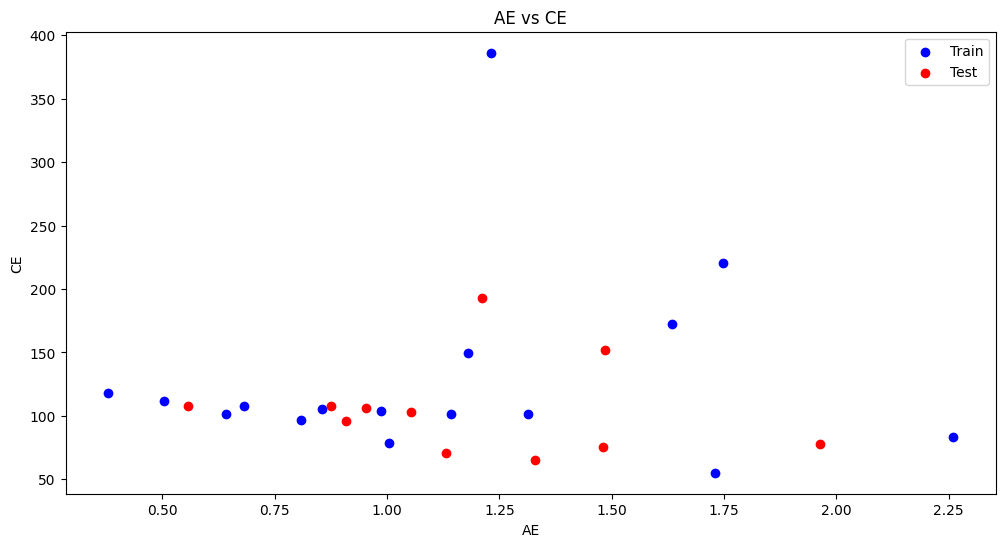

In [36]:
t1,t2,t3,t4, train_videos,test_videos=split_data_all_users(root_dataset_folder,users,users_per_video)

In [ ]:
read_sampled_unit_vectors_for_video(VIDEO_DATA_FOLDER,'coaster').shape

(30, 301, 3)

In [ ]:
partitions=partition_in_train_and_test(VIDEO_DATA_FOLDER,INIT_WINDOW,END_WINDOW,t1,t2,t4,t3)

In [ ]:
all_traces = {}
for video in videos:
    all_traces[video] = read_sampled_unit_vectors_by_users(VIDEO_DATA_FOLDER, video,users_per_video[video])

In [ ]:
all_saliencies = {}

In [ ]:
model_name

'pos_only'

In [ ]:
model,optimizer,criterion=TRACK_POS.create_pos_only_model(M_WINDOW=M_WINDOW,H_WINDOW=H_WINDOW,device=device)

In [ ]:
train_data=PositionDataset(partitions['train'],future_window=H_WINDOW,M_WINDOW=M_WINDOW,all_traces=all_traces,model_name=model_name,all_saliencies=all_saliencies)
train_loader=DataLoader(train_data,batch_size=BATCH_SIZE,shuffle=True, pin_memory=True, num_workers=0)

In [ ]:
sal=load_saliency(SALIENCY_FOLDER,'coaster')

In [ ]:
videos=get_video_ids(os.path.join(root_folder,'Jin_22','video_data'))
for video in videos:
    vid_len=get_video_length(os.path.join(root_folder,'Jin_22','video_data'),video)
    true_sal=load_true_saliency(os.path.join(root_folder,'Jin_22','true_saliency'),video).shape[0]
    if vid_len!=true_sal:
        print("unequal")

In [ ]:
true_sal.shape

(301, 256, 256)

In [43]:
datasets=[
          #'MM_18',
          #'Fan_NOSSDAV_17',
          'CVPR18',
          #'PAMI18',
          #'MMSys18',
          #'Jin_22'
          ]
for dataset in datasets:
    dataset_dir=os.path.join(root_folder,dataset)
    
    vid_data_path=os.path.join(dataset_dir,'video_data')
    vid_images=os.path.join(dataset_dir,'5fps_Video_Images')
    videos=os.listdir(vid_data_path)
    print(dataset_dir)
    for video in videos:
        image_paths=os.path.join(vid_images,video)
        traj_paths=os.path.join(vid_data_path,video)
        trajectory=np.load(os.path.join(traj_paths,f'{video}_unit_vectors.npy'))
        traj_tstamps=np.load(os.path.join(traj_paths,f'{video}_timestamps.npy'))
        
        images=np.load(os.path.join(image_paths,'sampled_video.npy'))
        video_tstamps=np.load(os.path.join(image_paths,'timestamps.npy'))
        if traj_tstamps.shape != video_tstamps.shape:
            print(video)
            print(traj_tstamps.shape)
            print(video_tstamps.shape)
    break
        

/media/Blue2TB1/CVPR18
001


: 

: 

In [13]:
train,test=split_data()

NameError: name 'split_data' is not defined

In [ ]:
si=np.load('/media/Blue2TB1/Jin_22/video_data/video_1/video_SI.npy')

FileNotFoundError: [Errno 2] No such file or directory: '/media/Blue2TB1/Jin_22/video_data/video_1/video_SI.npy'

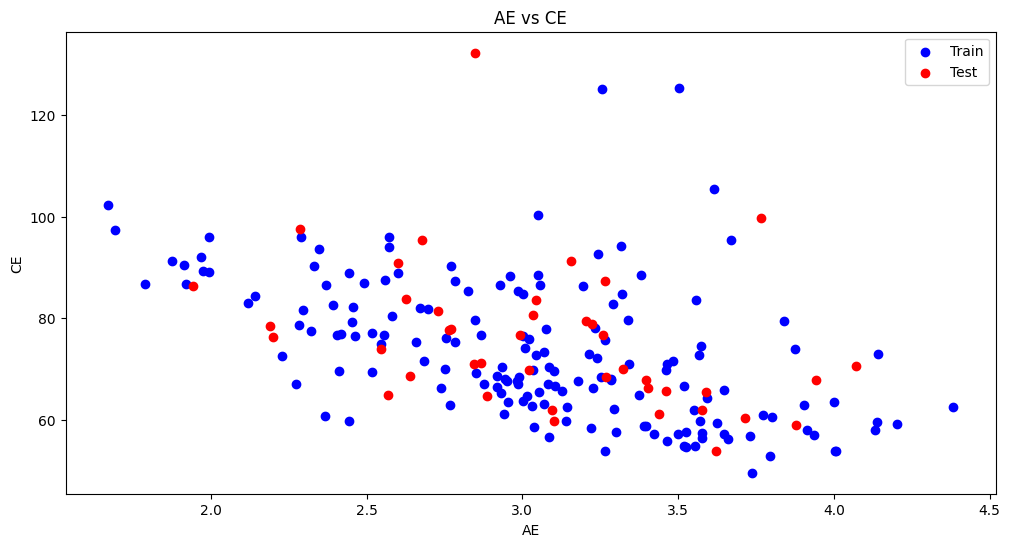

In [ ]:
dataset_dir='D:/CVPR18'
train,test=split_data(dataset_dir)

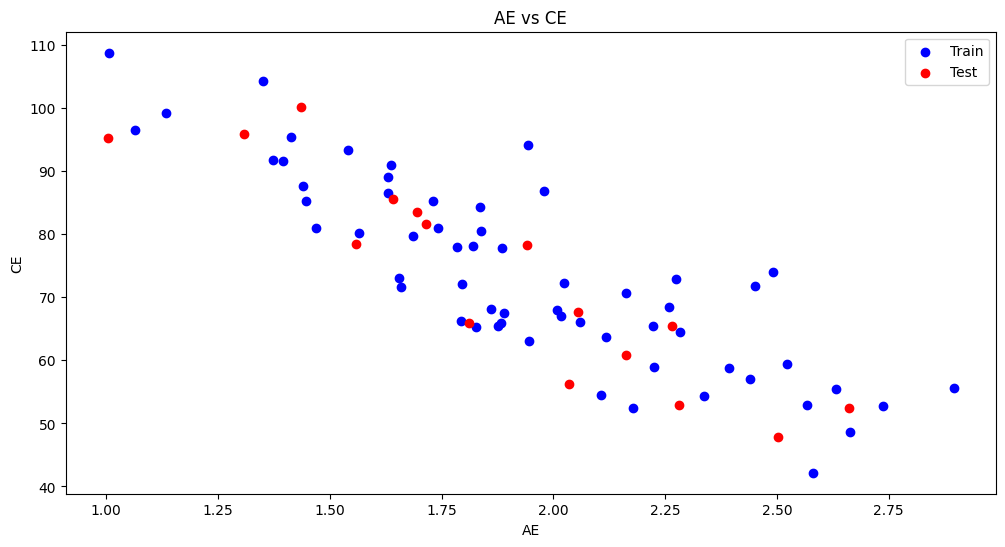

In [ ]:
dataset_dir='D:/PAMI18'
train,test=split_data(dataset_dir)